In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sys
import os

sys.stdout = open(os.devnull, 'w')

# Descargar los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')

sys.stdout = sys.__stdout__
new_col_names = ['time', 'Nombre', 'Email', 'Año Egreso', 'Situación Laboral', 'Área de Trabajo Actual', 'Puesto de Trabajo Actual','Desarrollo Profesional' ,'Comunicación efectiva','Trabajo en Equipo', 'Decisiones Estratégicas', 'Líder Exitoso', 'Cargos de mayor responsabilidad', 'Asignaturas Complementarias Liderazgo','Asignaturas Complementarias Fundamental', 'Comentario', 'Comentario2']
resultados = pd.read_csv('encuesta_exalumnos.csv')
resultados.columns = new_col_names
resultados['Comentario'] = resultados['Comentario'].fillna('') + resultados['Comentario2'].fillna('')
resultados.drop(columns=['Comentario2'], inplace=True)
df = resultados['Comentario'].dropna()
df = pd.DataFrame(df)

# Preprocesamiento: Tokenización y eliminación de stopwords
stop_words = set(stopwords.words('spanish'))
irrelevant_words = ('si', 'no', 'sí', 'bien', 'mal', 'así', 'ahí', 'aún', 'aun', 'aunque')

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [word for word in tokens if word not in irrelevant_words]
    return tokens

df['tokens'] = df['Comentario'].apply(preprocess)


In [4]:
# Entrenar el modelo de Word2Vec
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy")
model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Crear vectores promedio para cada comentario
def vectorize(tokens):
    vector = np.mean([model.wv[token] for token in tokens if token in model.wv], axis=0)
    return vector

df['vector'] = df['tokens'].apply(vectorize)


In [15]:
# Eliminar filas con valores NaN
df = df.dropna(subset=['vector'])

# Reducción de dimensionalidad
pca = PCA(n_components=25)
df['pca_vector'] = list(pca.fit_transform(np.array(df['vector'].tolist())))

# Clustering con K-Means
kmeans = KMeans(n_clusters=5)  # Cambia el número de clusters según sea necesario
df['cluster'] = kmeans.fit_predict(np.array(df['pca_vector'].tolist()))


In [ ]:
kmeas = KMeans(n_clusters=10, random_state=42, n_init=50)
kmeans.fit_predict(np.array(df['pca_vector'].tolist()))
df['cluster'] = kmeans.labels_
print (df['cluster'].value_counts())
df.to_csv('clusters.csv', index=False)

# Informe de análisis de contenido cuantitativo y cualitativo en comentarios.

En este informe se presenta los insights y una breve descripción de las técnicas utilizadas, en conjunto con gráficos explicativos y pequeños para ser analizados por equipos técnicos en conjunto de una presentación para socializar con equipos no técnicos. Para más detalle revisar el repositorio.

Comenzaremos observando a grandes rasgos los comentarios para tener una idea de que es lo que contienen antes de hacer una lectura individualizada una por una.

Se realiza una limpieza de texto usando stopwords, tokenizadores y lemantizadores, para así obtener la mayor cantidad de palabras que posean sentido. Además para algunos casos se aplicaron correcciones de familia de palabras para representarlas en un solo componente que acumule toda esa representatividad.

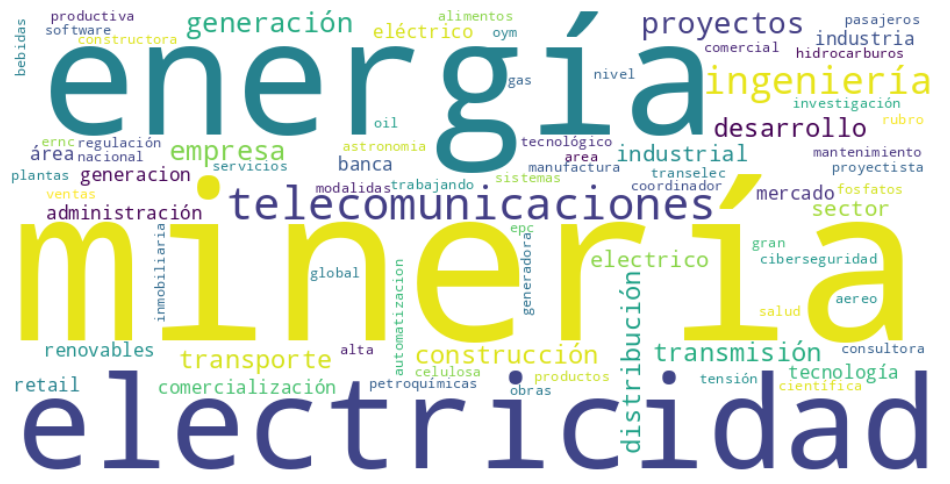

In [25]:
from wordcloud import WordCloud

# Clean the words in the 'Área de Trabajo Actual' column
cleaned_area = resultados['Área de Trabajo Actual'].dropna().astype(str).apply(preprocess)
cleaned_area = cleaned_area.explode().str.lower()

# Create a word cloud with the cleaned words
cleaned_area = cleaned_area.replace(['energia', 'energéticos'], 'energía')
cleaned_area = cleaned_area.replace('mineria', 'minería')
cleaned_area = cleaned_area.replace('tecnologia', 'tecnología')
cleaned_area = cleaned_area.replace(['ingenieria', 'ingeniaría'], 'ingeniería')
cleaned_area = cleaned_area.replace('telecomunicación', 'telecomunicaciones')
cleaned_area = cleaned_area.replace('electrica', 'electricidad')
cleaned_area = cleaned_area.replace(['electrico, eléctrico', 'eléctrica'], 'electricidad')
cleaned_area = cleaned_area.replace('softwarw', 'software')
cleaned_area = cleaned_area.replace('distribuidora', 'distribución')
cleaned_area.dropna(inplace=True)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cleaned_area.astype(str)))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Gráfico de nube de palabras que muestra a mayor tamaño las palabras, agrupadas por semántica, de mayor frecuencia de forma proporcional a su aparición en la sección de `Comentario`. Observamos que la industria de Energía es de gran presencia en conjunto con los rubros de eletricidad y minería. También destaca el aporte en telecomunicaciones de quienes respondieron la encuestra

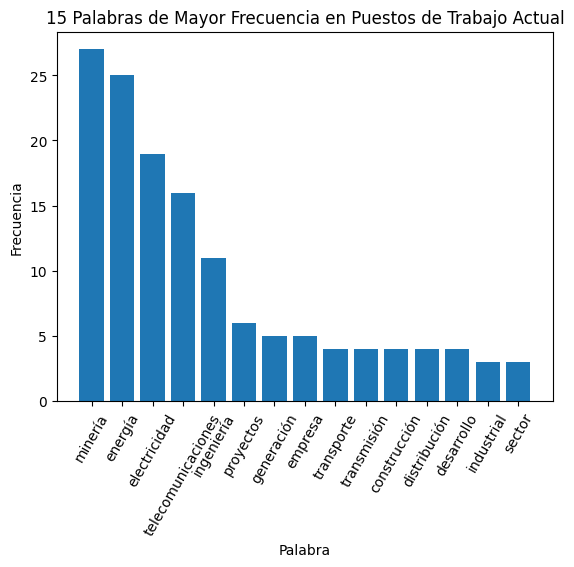

In [21]:
from collections import Counter

# Calcular la frecuencia de cada palabra en cleaned_area
word_freq = Counter(cleaned_area.explode())

# Seleccionar las 15 palabras con mayor frecuencia
top_words = word_freq.most_common(15)

# Obtener las palabras y sus frecuencias por separado
words = [word for word, freq in top_words]
freqs = [freq for word, freq in top_words]

# Crear el gráfico de columnas
plt.bar(words, freqs)
plt.title('15 Palabras de Mayor Frecuencia en Puestos de Trabajo Actual')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.xticks(rotation=60)
plt.show()

Para una mayor claridad se muestra el gráfico de frecuencia de la nube de palabras anterior ordenados de mayor a menor con los 15 primeros datos. Se puede ver cuantitativamente la dominacia de las 4 palabras más mencionadas.

## Análisis de Comentarios
Para esta sección se utilizaron bibliotecas de lenguaje natural para tokenizar y lemantizar la respuesta con el objetivo de poder agruparlas

Hay que recalcar que según el análisis exploratorio cuantitativo, estas respuesta no presentan correlación entre largo del comentario, sentimiento ni puntuación promedio. Si podrían, como toda respuesta abierta, presentar sesgo en relación a la visión subjetiva de cada persona, pero según lo mencionado anteriormente, esto se debería distribuir homogeneamente independiente del puntaje promedio o largo del comentario.

Como insumo inicial se recibe una preclasificación manual en 8 categorías que son

1. Mejora en habilidades blandas y liderazgo
2. Actualización y relevancia de contenido tecnológico.
3. Vinculación con la Industria.
4. Formación complementaria.
5. Adaptación a nuevas tecnologías.
6. Estructura y flexibilidad curricular.
7. Apoyo de la formación y desarrollo profesional.
8. Comentarios Generales y Sugerencias

Cruzaremos esta información con lo encontrado mediante la vectorización , clusterización y recuento de los datos limpios.

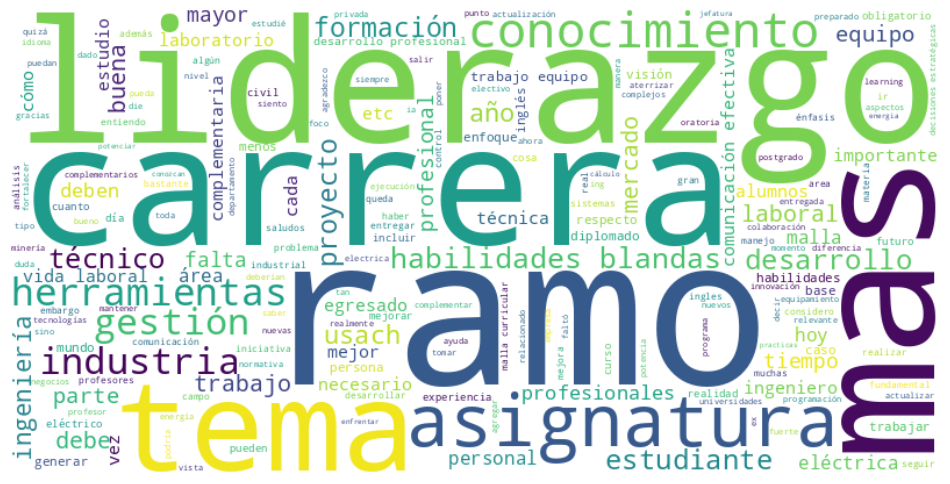

In [36]:
from wordcloud import WordCloud

# Create a word cloud with the words from the 'tokens' column
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['tokens'].explode()))
plt.figure(figsize=(12, 12))
# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

El primer análisis muestra presencia de mucho ruido con palabras que no necesariamente aportan al análisis, como univerisdad, carrera, por lo que limpiaremos un poco más los datos y procederemos al análisis

In [52]:

irrelevant_words = ('si', 'no', 'sí', 'bien', 'mal', 'así', 'ahí', 'aún', 'aun', 'aunque', 'etc')
more_irrelevant_words = ('universidad','uasch', 'solo', 'tener', 'ser', 'poder', 'hacer', 'hace', 'hacen', 'haciendo', 'hizo', 'hace', 'alumno', 'creo', 'estudiante', 'hoy', 'año')

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [word for word in tokens if word not in irrelevant_words]
    tokens = [word for word in tokens if word not in more_irrelevant_words]
    return tokens

# Clean the words in the 'Área de Trabajo Actual' column
cleaned_comments = df['Comentario'].dropna().astype(str).apply(preprocess)
cleaned_comments = cleaned_comments.explode().str.lower()

cleaned_comments = cleaned_comments.replace(['ramo', 'ramos', 'asignatura'], 'asignaturas')
cleaned_comments = cleaned_comments.replace(['carrera', 'carreras'], 'carrera')
cleaned_comments = cleaned_comments.replace('debe', 'deben')


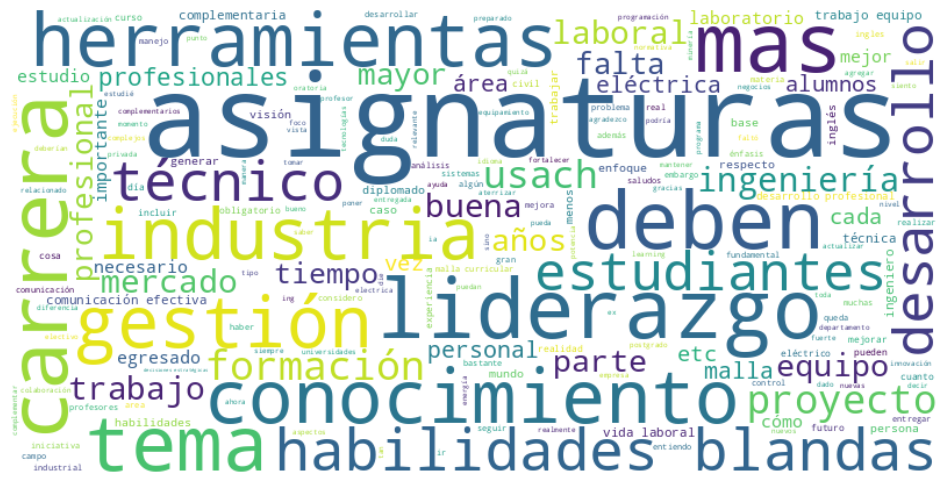

In [50]:
# Create a word cloud with the words from the 'tokens' column
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cleaned_comments.astype(str)))
plt.figure(figsize=(12, 12))
# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Después de la limpieza podermos notar lo siguiente:
1. Hay una visión tradicional sobre la formación profesional debido a que `Asignaturas` toman una relevancia por encima de prácticas, terrenos o proyectos presuponiendo que mucha de las competencias desarrolladas se suponen logradas o no logradas de esta manera. Podemos relacionar esta palabra con `Conocimiento` directamente.
2. La palabra `Liderazgo` también toma relevancia, esto es concordante con el insight encontrado en los datos cuantitativos. Aunque no sabemos aun si estos comentarios son positivos o negativos en relación a la formación, podría estar sesgada debido al bajo puntaje que obuto liderazgo en la encuesta y también al ser una de las últimas preguntas del cuestionario, influenciar una crítica hacia este sector.
3. Otra de las palabras que resaltan son `Habilidades blandas` y `Herramientas`. En un sentido estricto se relaciona con inteligencia emocional, comunicación, que se debería desarrollar de forma transversal a lo largo de la formación, pero que puede ser complicado de compatibilizar con una educación tradicional o demasiado conductista. La realización o gestión a nivel académico puede ayudar a mejorar esta área. En la nube también destacan palabras como `Proyecto`, `Gestión`
4. `Deben` salta a la vista como un llamado a la acción. Quienes responden la encuesta esperan mejoras que sienten urgentenes y necesarias por la imperatividad del verbo.
5. Otras palabras como `Tema`, `Industria`, `Desarrollo`o `Carrera` podrían indicar una sensación de incompletitud de ciertas competenciaso o ausencia de la posibilidad de desarrollo en ciertas temáticas que en la industria son necesitadas o forman parte de nuevas tendencias tecnológicas.

Finalmente, indicar que el análisis de comentario debe hacerse cuidadosamente leyendo cada respuesta por parte de quienes deben tomar decisiones, puesto que la visión experta en temas de ingeniería eléctrica tomará atención a detalles que no podemos observar con claridad.

Además, una mayor frecuencia o no de comentarios catalogados y agrupados puede no ser eficiente o mostrar pequeñas debilidades en la formación, ya que podría ser escrito de forma superficial sin pensar detenidamente en profundidad sobre el tema tratado, mientras que un solo comentario reflexivo hecho con intención de aportar, puede abrir puertas a una conversación y debate interesante sobre nuevos lineamientos. Solo recordar que, aunque sea polémico, la mayoría no siempre tiene la razón.

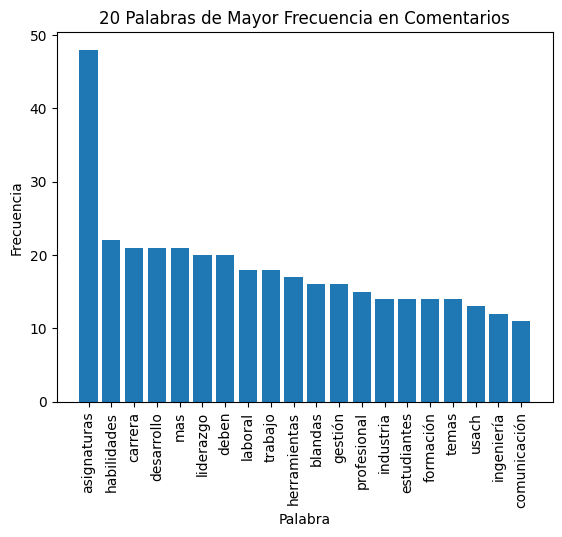

In [59]:

# Calcular la frecuencia de cada palabra en cleaned_area
word_freq = Counter(cleaned_comments.explode())

# Seleccionar las 15 palabras con mayor frecuencia
top_words = word_freq.most_common(20)
# Obtener las palabras y sus frecuencias por separado
words = [word for word, freq in top_words]
freqs = [freq for word, freq in top_words]

# Crear el gráfico de columnas
plt.bar(words, freqs)
plt.title('20 Palabras de Mayor Frecuencia en Comentarios')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()

Sobre el gráfico de frecuencia se puede notar claramente la presencia de asignatura como más del doble de la segunda en frecuencia, y como estas se mantienen con una frecuencia sin mucha variación hasta el puesto 20. Esto es claro porque la imagen que se lleva un nuevo estudiante, o un estudiante egresado es mayoritariamente el plan de estudios con las asignaturas cursadas, despotenciando las otras instancias de mejora y desarrollo que una institución puede ofrecer.

### Agrupación

Al cruzar la información obtenida mediante el análisis de palabras con la preclasificación podemos generar:

1. Mejora en habilidades blandas y liderazgo + Apoyo de la formación y desarrollo profesional.
2. Actualización y relevancia de contenido tecnológico + Adaptación a nuevas tecnologías. 
3. Vinculación con la Industria + Formación complementaria.
4. Estructura y flexibilidad curricular.
5. Comentarios Generales y Sugerencias

Con estas 5 categorías iniciamos el análisis de contenido para categorizar cada respuesta en uno de estos grupos, y en caso de solamiento poder revisar las categorías o poder generar una nueva.
Estas categorías serán definidas mediante la palabra inicial de cada frase. `Mejora, Actualización, Vinculación, Estructura, Comentarios`



In [76]:
cluster_manual = pd.read_excel('clasicicacion manual.xlsx')
cluster_manual.value_counts('cluster_final')

cluster_final
1.0    37
5.0    25
3.0    21
4.0    19
2.0    17
Name: count, dtype: int64

In [97]:
resultados['cluster'] = cluster_manual['cluster_final']
df['cluster'] = cluster_manual['cluster_final']

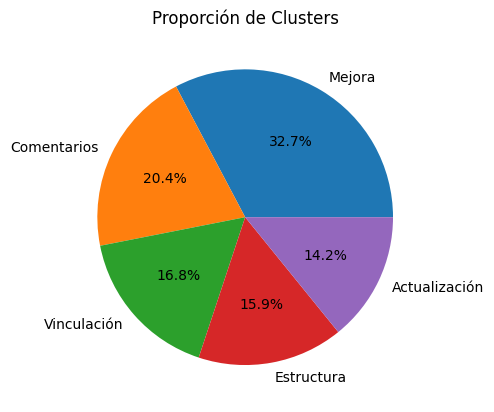

In [136]:
import matplotlib.pyplot as plt

# Count the occurrences of each cluster
cluster_counts = df['cluster'].value_counts()
rename_clusters = {1: 'Mejora', 2: 'Actualización', 3: 'Vinculación', 4: 'Estructura', 5: 'Comentarios'}
cluster_counts = cluster_counts.rename(rename_clusters)
# Create a pie chart
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%')
plt.title('Proporción de Clusters')
plt.show()
# Add labels to the pie chart
labels = ['Mejora', 'Actualización', 'Vinculación', 'Estructura', 'Comentarios']


La clasificación arroja clases semi balanceadas, donde Mejora tiene el doble de clasificaciones que Vinculación, Estructura y Actualización, pero se acepta esto debido a la naturaleza de la encuesta, donde quienes responden buscan la mejora continua de la carrera de la que egresaron.

Una revisión exhaustiva de los comentarios puede hacerse mediante el insumo adjuntado donde los comentarios se clasifican por cluster.
Hallazgos:

### Descubrimientos

1. Mejora: 
- Los comentarios indican falencias en el desarrollo de habilidades de liderazgo según las exigencias de los cargos que se están ocupando. 
- Se menciona explícitamente la falta de habilidad blandas.
- Si bien se sienten reconocidos y competentes laboralmente por sus aptitudes técnicas, han tenido que complementar con estudios superiores en otras casas de estudio para poder seguir escalando y llegar a posiciones de gerencia.
- También se menciona 

2. Actualización:
- Tener acceso a distintas áreas de formación como electromovilidad, oil & gas y otras tecnologías vanguardistas.
- Enfocar mayor estudio de programación y temas de IA.
- Modernizar los laboratorios e instalaciones.
- Innovar en el uso de herramientas digitales de las asignaturas.

3. Vinculación:
- Trabajar temáticas como gestión, negociación y otras habilidades requeridas en la industria.
- Desarrollar más habilidades para emprender.
- Asignaturas de comunicación efectiva, oratoria para desenvolverse en la industria.
- Conocer y aplicar normativas actuales según estándares.
- Generar profesionales bilingues.

4. Estructura:
- Mayor flexibilidad para cursar electivos de otras carreras para obtener un profesional que sepa trabajar con distintos equipos multidisciplinarios como ocurre en la industria.
- Menor profundización en temas complejos y mayor en cuanto a las áreas complementarias.
- Agregar formación en visión financiera y económica, además de ética profesional y algún conocimiento humanista.

5. Comentarios:
- Se valora la instancia para retroalimentar, se espera que siga ocurriendo este proceso de forma continua y no sea esporádico o temporal.
- Hay interés de egresados y egrasadas que desean compartir más tiempo mediante entrevistas para dar su retroalimentación y visión sobre la carrera sumando sus años de experiencia en la industria.



Un mayor detalle se puede obtener revisando los comentarios completos en el archivo que se indica.


# Conclusiones

- Se refuerza y comprueba la idea obtenida en el análisis cuantitativo de que la formación de la casa de estudio tiene su debilidad en el liderazgo y gestión de equipos de trabajo cuando los estudiantes alcanzan altos niveles de liderazgos en las empresas.
- Egresados que han optado por la continuidad de estudios, según lo declarado en comentario, lo han hecho para solapar las debilidades en formación de ldierazgo y gestión de equipos que han obtenido en esta institución, sin embargo, valoran y reconocen que las competencias técnicas enseñadas les han sido de gran valor y forma parte de un reconocimiento colectivo que se tiene de la carrera.
- Comentarios de egresados de hace más de 10 años dan fé de las mejoras estructurales de la malla académica, pero concuerdan en las mismas debilidades de los egresados hace menos tiempo.
- Quienes respondan la encuesta entienden que es necesaria una mayor flexibilidad a la hora de poder formarse profesionalemente y que los requerimientos actuales de la industria van orientados a las habilidades blandas, manejo de nuevas tecnologías, organizaciónd de equipos de trabajo en contra de un fuerte conocimiento en variadas áreas.